# FamilySizeによってカテゴリわけ
# トレーニングデータを増やす

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic/test.csv")
test_survive = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic/expand.csv")
test["Survived"] = test_survive.iloc[:, 1]
test = test[["PassengerId", "Survived", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]]

# 前処理

- Ageの補完とSexを3分割は前回と同じ

In [0]:
middle = data["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
data["Middle"] = middle[0]
data.loc[(data["Middle"] != "Mr") 
         & (data["Middle"] != "Mrs") 
         & (data["Middle"] != "Miss") 
         & (data["Middle"] != "Master"), "Middle"] = "Other"
data.loc[(data["Middle"] == "Other") 
         & (data["Age"] < data.loc[data["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
data.loc[(data["Middle"] == "Other"), "Middle"] = "Other_post"
data.loc[data["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    data.loc[(data["Age"].isnull()) & (data["Middle"] == middle), "Age"] = data.loc[
        data["Middle"] == middle, "Age"].dropna().median()
data.loc[(data["Middle"] == "Mr") & (data["Sex"] == "male"), "Sex"] = "Mr"
data.loc[(data["Middle"] != "Mr") & (data["Sex"] == "male"), "Sex"] = "notMr"

### テストデータに対しても同じ操作を行う(補完に関しては前回と同じ)

In [0]:
middle = test["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
test["Middle"] = middle[0]
test.loc[(test["Middle"] != "Mr") 
         & (test["Middle"] != "Mrs") 
         & (test["Middle"] != "Miss") 
         & (test["Middle"] != "Master"), "Middle"] = "Other"
test.loc[(test["Middle"] == "Other") 
         & (test["Age"] < test.loc[test["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
test.loc[(test["Middle"] == "Other"), "Middle"] = "Other_post"
test.loc[test["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    test.loc[(test["Age"].isnull()) & (test["Middle"] == middle), "Age"] = test.loc[
        test["Middle"] == middle, "Age"].dropna().median()
test["Fare"] = test["Fare"].fillna(test.loc[test["Middle"] == "Mr", "Fare"].dropna().median())
test.loc[(test["Middle"] == "Mr") & (test["Sex"] == "male"), "Sex"] = "Mr"
test.loc[(test["Middle"] != "Mr") & (test["Sex"] == "male"), "Sex"] = "notMr"

### 特徴量FamilySizeの導入

In [0]:
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

### Cabin

In [0]:
data["Cabin"] = data["Cabin"].fillna(0)
data.loc[data["Cabin"] != 0, "Cabin"] = 1
test["Cabin"] = test["Cabin"].fillna(0)
test.loc[test["Cabin"] != 0, "Cabin"] = 1

In [0]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Middle,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",Mr,22.0,1,0,A/5 21171,7.2500,0,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",Mr,35.0,0,0,373450,8.0500,0,S,Mr,1
5,6,0,3,"Moran, Mr. James",Mr,30.0,0,0,330877,8.4583,0,Q,Mr,1
6,7,0,1,"McCarthy, Mr. Timothy J",Mr,54.0,0,0,17463,51.8625,1,S,Mr,1
7,8,0,3,"Palsson, Master. Gosta Leonard",notMr,2.0,3,1,349909,21.0750,0,S,Master,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S,Mrs,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C,Mrs,2


### Embarked

In [0]:
data["Embarked"] = data["Embarked"].fillna("S")

# FamilySizeについて考察

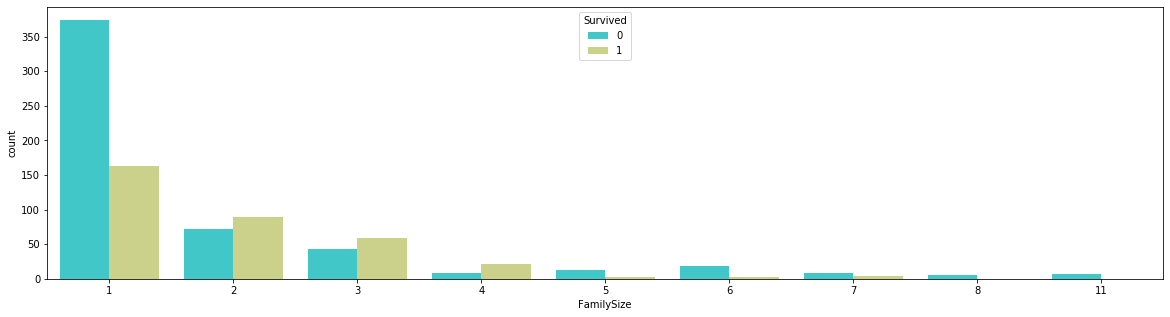

In [0]:
plt.figure(figsize=(20, 5))
sns.countplot('FamilySize', data=data, hue='Survived', palette='rainbow')
plt.show()

- FamilySizeが1のときと、5以上の時の死亡率が高い

In [0]:
data["FamilySize_1"] = 0
data["FamilySize_mid"] = 0
data["FamilySize_big"] = 0
data.loc[data["FamilySize"] == 1, "FamilySize_1"] = 1
data.loc[(data["FamilySize"] > 1) & (data["FamilySize"] < 5), "FamilySize_mid"] = 1
data.loc[data["FamilySize"] >= 5, "FamilySize_big"] = 1
test["FamilySize_1"] = 0
test["FamilySize_mid"] = 0
test["FamilySize_big"] = 0
test.loc[test["FamilySize"] == 1, "FamilySize_1"] = 1
test.loc[(test["FamilySize"] > 1) & (test["FamilySize"] < 5), "FamilySize_mid"] = 1
test.loc[test["FamilySize"] >= 5, "FamilySize_big"] = 1

# トレーニングデータを増やす

In [0]:
data = pd.concat([data, test])

# X, yに分ける

In [0]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Middle,FamilySize,FamilySize_1,FamilySize_mid,FamilySize_big
0,1,0,3,"Braund, Mr. Owen Harris",Mr,22.0,1,0,A/5 21171,7.2500,0,S,Mr,2,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,Mrs,2,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,1,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,Mrs,2,0,1,0
4,5,0,3,"Allen, Mr. William Henry",Mr,35.0,0,0,373450,8.0500,0,S,Mr,1,1,0,0


In [0]:
X = data.drop(["PassengerId", "Survived", "Name", "SibSp", "Parch", "Ticket", "Middle", "FamilySize"], axis=1)
y = data["Survived"]
X_test = test.drop(["PassengerId", "Survived", "Name", "SibSp", "Parch", "Ticket", "Middle", "FamilySize"], axis=1)

In [0]:
X.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize_1,FamilySize_mid,FamilySize_big
0,3,Mr,22.0,7.2500,0,S,0,1,0
1,1,female,38.0,71.2833,1,C,0,1,0
2,3,female,26.0,7.9250,0,S,1,0,0
3,1,female,35.0,53.1000,1,S,0,1,0
4,3,Mr,35.0,8.0500,0,S,1,0,0


# ワンホットエンコーディング

- Pclass, Sex -> ワンホットエンコーディング

In [0]:
X = pd.get_dummies(X, columns=["Pclass"])
X = pd.get_dummies(X, columns=["Sex"])
X = pd.get_dummies(X, columns=["Embarked"])
X_test = pd.get_dummies(X_test, columns=["Pclass"])
X_test = pd.get_dummies(X_test, columns=["Sex"])
X_test = pd.get_dummies(X_test, columns=["Embarked"])

# 標準化

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))
X_test = pd.DataFrame(sc.fit_transform(X_test))

In [0]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.569214,-0.503221,-0.539377,-1.233758,1.412595,-0.258514,-0.572351,-0.518084,0.919925,0.853929,-0.743497,-0.265177,-0.50977,-0.32204,0.655011
1,0.644408,0.734785,1.853992,-1.233758,1.412595,-0.258514,1.747178,-0.518084,-1.087045,-1.171058,1.344995,-0.265177,1.96167,-0.32204,-1.526692
2,-0.265808,-0.490171,-0.539377,0.810532,-0.707917,-0.258514,-0.572351,-0.518084,0.919925,-1.171058,1.344995,-0.265177,-0.50977,-0.32204,0.655011
3,0.416854,0.383233,1.853992,-1.233758,1.412595,-0.258514,1.747178,-0.518084,-1.087045,-1.171058,1.344995,-0.265177,-0.50977,-0.32204,0.655011
4,0.416854,-0.487754,-0.539377,0.810532,-0.707917,-0.258514,-0.572351,-0.518084,0.919925,0.853929,-0.743497,-0.265177,-0.50977,-0.32204,0.655011


拡張したトレーニングデータを用いて、Votingを行う。

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, C=10)
svm = SVC(C=1, gamma=0.1)
dt = DecisionTreeClassifier(criterion="gini", max_depth=8, max_features="log2", min_samples_leaf=1, min_samples_split=7)
rf = RandomForestClassifier(max_depth=6, max_features=5, min_samples_split=2, n_estimators=300)

vote_clf =  VotingClassifier([('lr', lr), ('svm', svm), ('dt', dt), ('rf', rf)], weights=(1, 1, 1, 1))
scores = cross_val_score(vote_clf, X, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))
vote_clf.fit(X, y)

Cross-Validation scores: [0.83536585 0.85932722 0.85015291 0.96941896]
Average score: 0.878566234056836


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=10000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SVC(C=1, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_s...
                                                     class_weight=None,
                                      

# 提出用ファイルを作成

In [0]:
pred = vote_clf.predict(X_test)
submit = pd.DataFrame({"PassengerId":test["PassengerId"], "Survived":pred})
submit.to_csv("/content/drive/My Drive/Colab Notebooks/titanic/gender_submission.csv",index=False)

In [0]:
from google.colab import files
files.download("/content/drive/My Drive/Colab Notebooks/titanic/gender_submission.csv")

# 結果

- 80.38%